#### 回归测试

skip越大越能看出效果。预测结果基本上与实际结果误差为skip值+1.

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import logging
import pandas as pd
import stock_ai
import stock_ai.preprocessing
from stock_ai import data_processor
from stock_ai import calcs


import numpy as np
from keras import layers
from keras.models import Sequential
from stock_ai.ploter import plot_keras_history
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import keras.optimizers

PLEASE install TALIB to call these methods
PLEASE install TALIB to call these methods


Using TensorFlow backend.


In [2]:
def get_stock_daily(code: str = '601398') -> pd.DataFrame:
    df = data_processor.load_stock_daily(code, online=False, fq=None)
    logging.debug("Load Daily:" + code)
    return df


def get_index_daily(code: str = '399300') -> pd.DataFrame:
    df = data_processor.load_index_daily(code, online=False)
    logging.debug("Load Daily:" + code)
    return df

index_code='399300'

def get_data_df(**kwargs):
    df_stock = get_stock_daily()
    df_index = get_index_daily()
    # df_601939 = get_stock_daily('601939')  #建设银行
    # df_601328 = get_stock_daily('601328')  #交通银行
    # df_600036 = get_stock_daily('600036')  #招商银行
    # df_601988 = get_stock_daily('601988')  #中国银行
    # df_601288 = get_stock_daily('601288')  #农业银行

#     s_601398=StockCN('601398')

    df = df_index.join(df_stock, how='left', lsuffix=index_code)

    other_code=[]

#     for code in ['601339','601328','600036','601988','601288']:
#         s=StockCN(code)
#         if s.ipo_date<=s_601398.ipo_date:
#             other_code.append(code)
#             df = get_stock_daily(code).join(df, how='left', lsuffix=code)

    df['need_is_sus'] = calcs.is_trade_suspension(df)
    df.fillna(method='ffill', inplace=True)

#     df[['need_BOLL_5_2','need_UB_5_2','need_LB_5_2']]=calcs.indicators.QA_indicator_BOLL(df,N=5,P=2)
#     df[['need_BOLL_10_2','need_UB_10_2','need_LB_10_2']]=calcs.indicators.QA_indicator_BOLL(df,N=10,P=2)
#     df[['need_BOLL_15_2','need_UB_105_2','need_LB_15_2']]=calcs.indicators.QA_indicator_BOLL(df,N=15,P=2)
#     df[['need_MTM_10_5','need_MTMMA_10_5']]=calcs.indicators.QA_indicator_MTM(df,N=10,M=5)
#     df[['need_MTM_15_10','need_MTMMA_15_10']]=calcs.indicators.QA_indicator_MTM(df,N=15,M=10)
#     df[['need_DIF_5_15_10','need_DEA_5_15_10','need_MACD_5_15_10']]=calcs.indicators.QA_indicator_MACD(df,short=5,long=15,mid=10)

    for code in ['',index_code]+other_code:
        df['need_close'+code]=df['close'+code]
        df['need_volume'+code]=df['volume'+code]

    df.dropna(inplace=True)

    col_y = 'need_close'
    col_x = [col for col in df.columns if 'need_' in col]

    # df = merge(
    #     {
    #         test.stock_code: df_stock,
    #         test.index_code: df_index,
    #         # '601939': df_601939,
    #         # '601328': df_601328,
    #         # '600036': df_600036,
    #         # '601988': df_601988,
    #         # '601288': df_601288
    #     },
    #     append_funcs=_get_append_funcs())
    # col_x, col_y = _get_columns(df)
    # print(df[col_x])
    return df, col_x, col_y


def norm(df):
    x = df.values  # returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

def get_data(f=None, **kwargs):
    df, col_x, col_y = get_data_df()

    x = []
    y = []

    df = norm(df)

    window = kwargs.pop('window', 5)
    days = kwargs.pop('days', 1)
    skip=kwargs.pop('skip',0)

    p1 = stock_ai.preprocessing.P1(x_cols=col_x,
                                   y_cols=col_y,
                                   window=window,
                                   days=days,
                                  skip=skip)
    x, y = p1.trans_to_numpy(data=df, norm_func=None)

    return x, y, col_x, col_y

def plot_pred_compare_real(real, pred, **kwargs):
    plots = []
    d = pd.DataFrame({'real': real, 'pred': pred.reshape(pred.shape[0])})
    # d['c']=abs(d['pred']-d['real'])/d['real']
    # print(d)
    ax = sns.lineplot(data=d)
    title = kwargs.pop('title', None)
    if title:
        ax.set_title(title, fontsize='x-small')

    fig, axs = plt.subplots(nrows=2)
    sns.lineplot(data=d, ax=axs[0])
    c=pd.DataFrame((d['pred'] - d['real']) / d['real'])
    sns.lineplot(data=c,ax=axs[1])
    print(c.describe())
    plt.tight_layout()
    plt.show()

x_col:['need_is_sus', 'need_close', 'need_volume', 'need_close399300', 'need_volume399300']
y_col:need_close
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 5, 256)            268288    
_________________________________________________________________
lstm_19 (LSTM)               (None, 5, 256)            525312    
_________________________________________________________________
lstm_20 (LSTM)               (None, 5, 128)            197120    
_________________________________________________________________
lstm_21 (LSTM)               (None, 5, 64)             49408     
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,052,577
Trainable

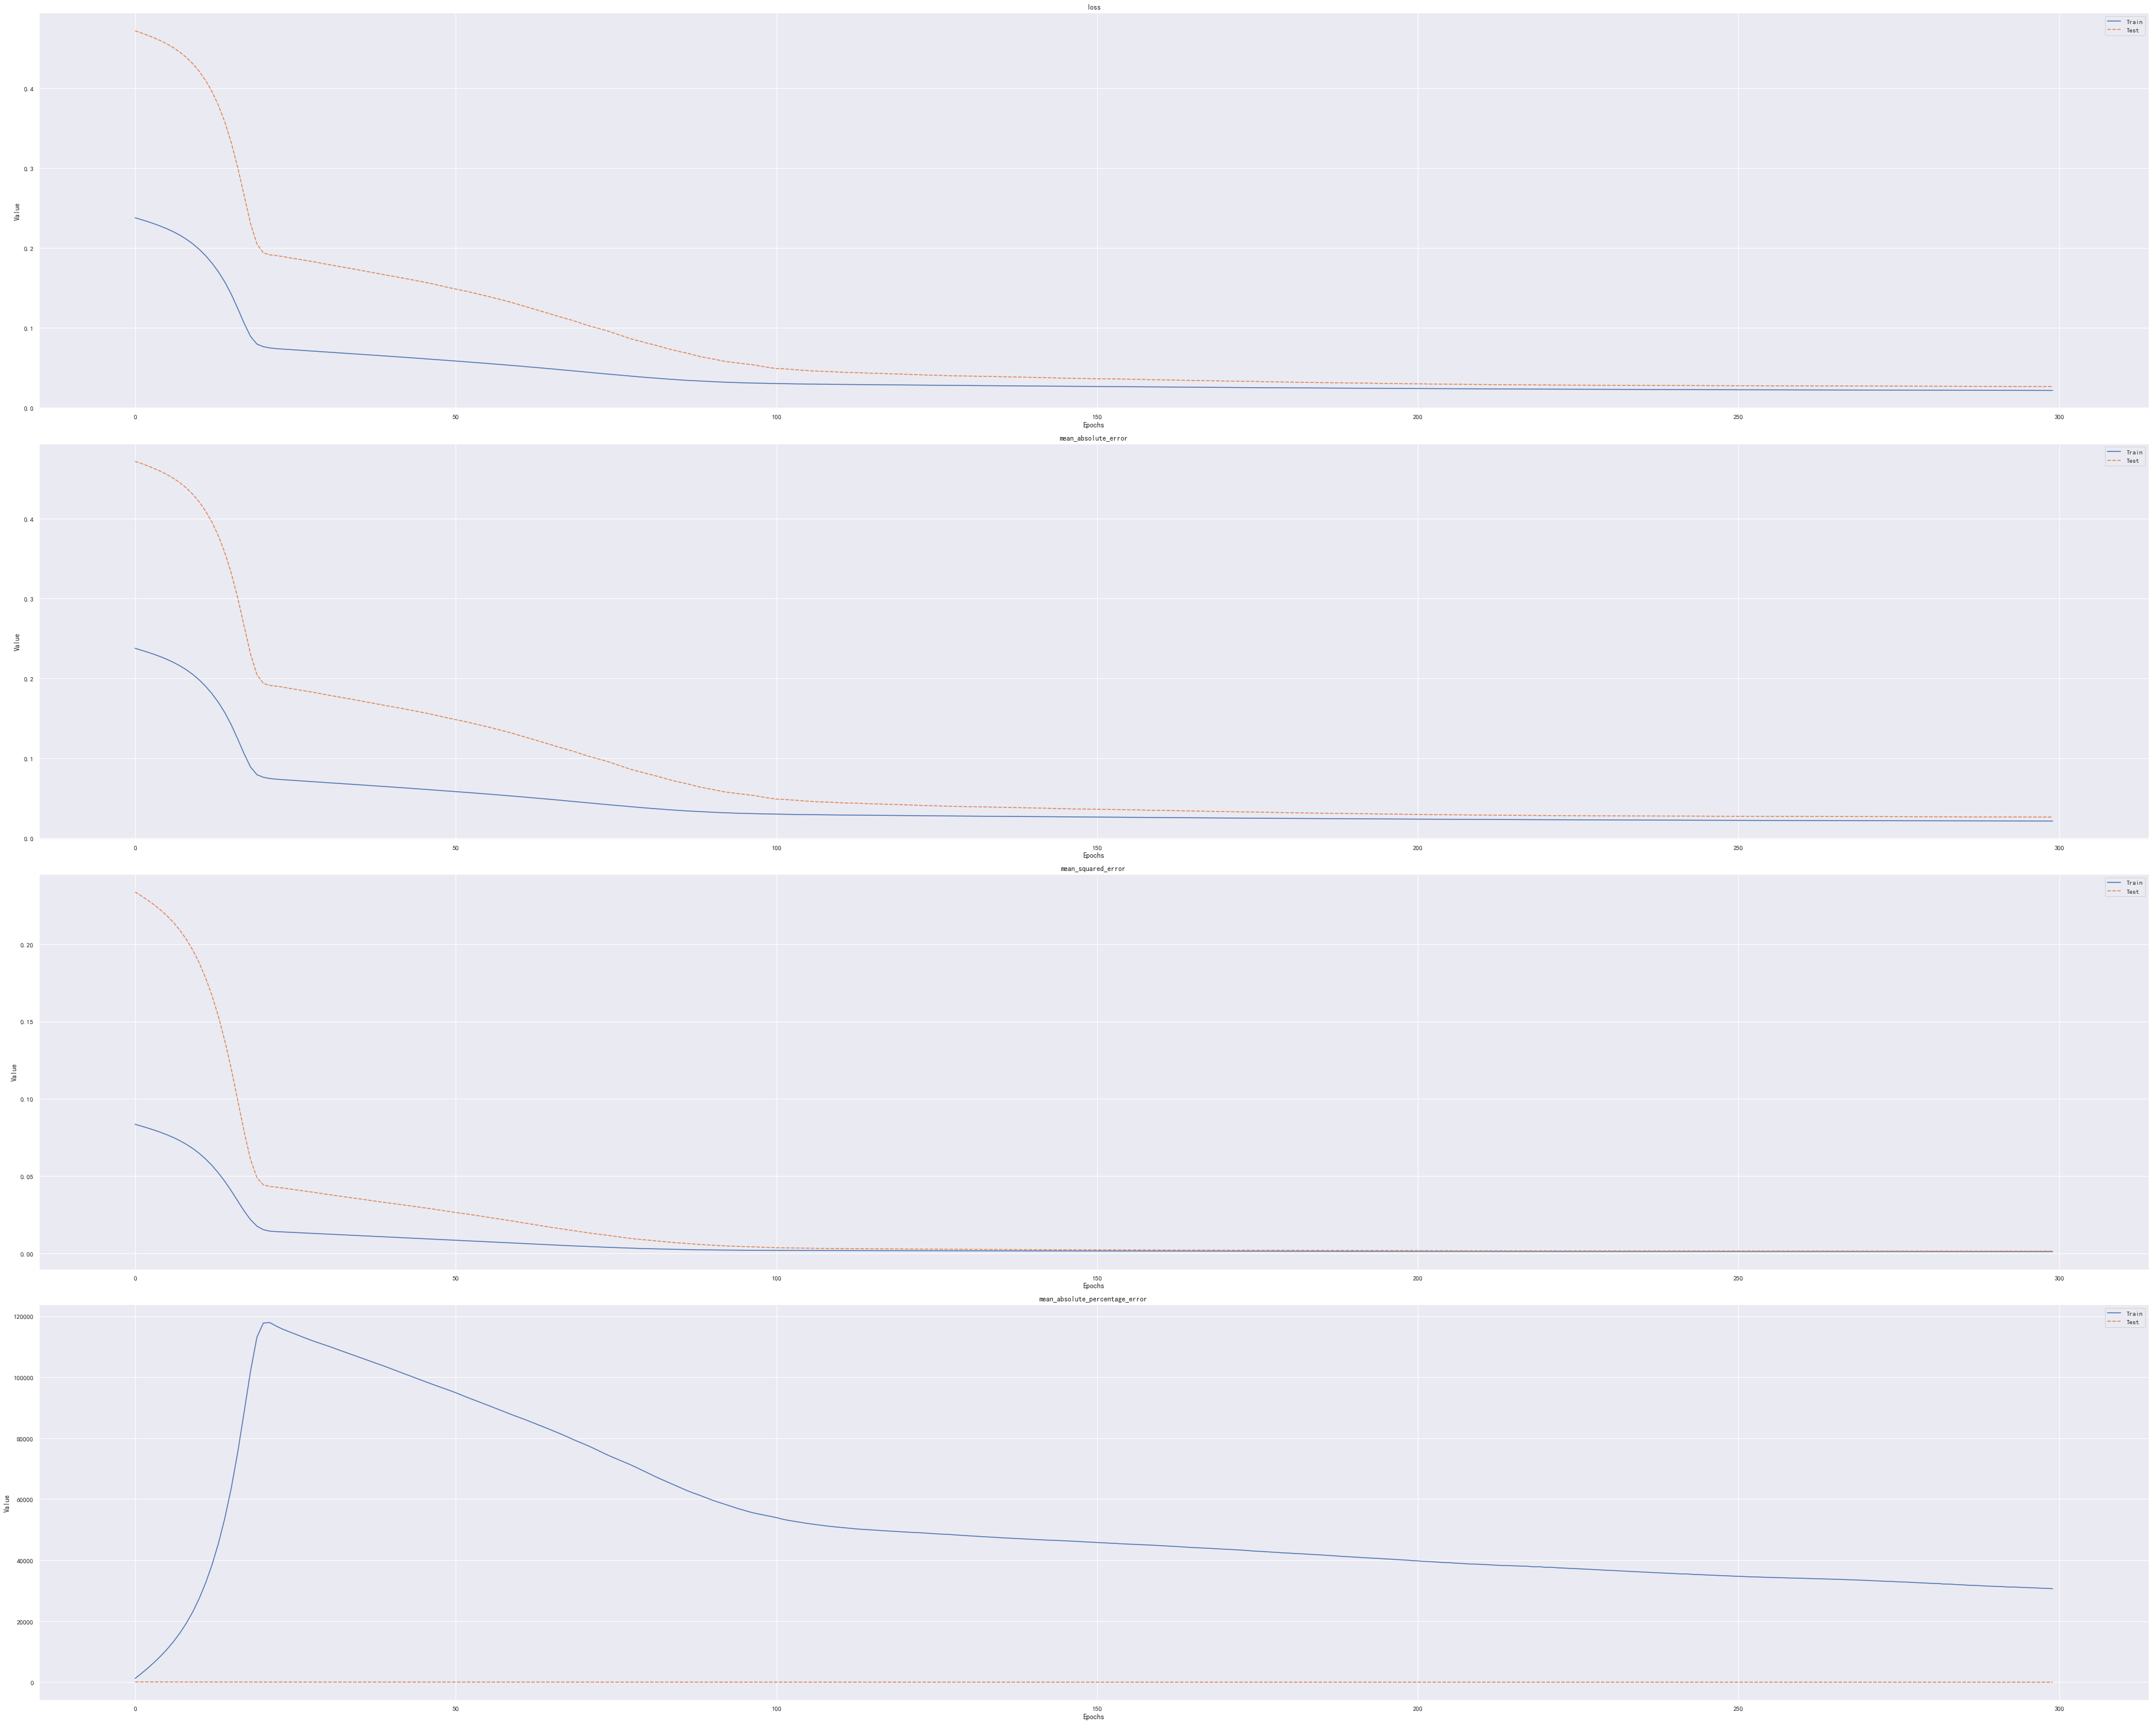

                0
count  149.000000
mean    -0.031591
std      0.071969
min     -0.189121
25%     -0.070850
50%     -0.038319
75%      0.004328
max      0.194011


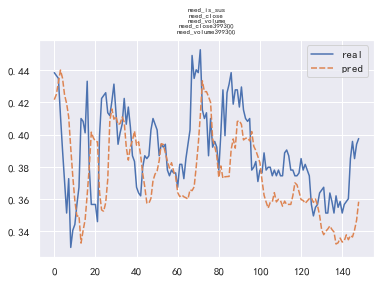

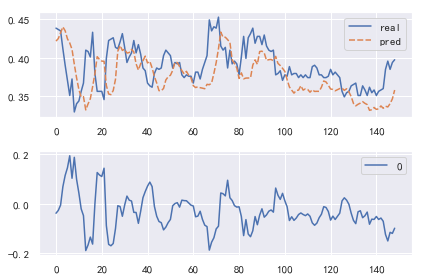

In [9]:
x, y, x_col, y_col = get_data(None,skip=0)

train_size = (int)(y.shape[0] * 0.95)
train_x = x[:train_size]
train_y = np.reshape(y[:train_size], len(y[:train_size]))
test_x = x[train_size:]
test_y = np.reshape(y[train_size:], len(y[train_size:]))

# print(train_x[0])
# print(train_x[1])
# print(train_y[0])

model = Sequential()
model.layers.append(
    layers.LSTM(256, input_shape=x[0].shape, return_sequences=True))
model.layers.append(layers.LSTM(256, return_sequences=True))
model.layers.append(layers.LSTM(128, return_sequences=True))
model.layers.append(layers.LSTM(64, return_sequences=True))
model.layers.append(layers.LSTM(32))
# model.layers.append(layers.LSTM(256, input_shape=x[0].shape))
model.layers.append(layers.Dense(1))

opt=keras.optimizers.Adam(lr=0.00001)

model.compile(
#     optimizer='adam',
    optimizer=opt,
                  loss='mae',
                  metrics=['mae', 'mse', 'mape'])

history = model.fit(train_x,
                        train_y,
                        batch_size=128,
                        epochs=300,
                        shuffle=False,
                        validation_split=0.1,
                        verbose=0,
#                         callbacks=[EarlyStopping(monitor='mean_absolute_error')]
                        )
print('x_col:{}'.format(x_col))
print('y_col:{}'.format(y_col))
model.summary()
plot_keras_history(history)

pred_y = model.predict(test_x)
plot_pred_compare_real(test_y, pred_y, title="\n".join(x_col))